<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (WIP) 09. PyTorch Model Deployment

Welcome to Milestone Project 3: PyTorch Model Deployment!

**Status:** Work in progress.

Goal: Take FoodVision Mini model and make it publically accessible (deploy it to a usable app/interface), want it to be:
* Fast (a slow app is a boring app)
* Good (95%+ accuracy for 3 classes but this would be harder to achieve with more classes)

--
* TK - What is model deployment?
    * TK - PyTorch workflow + model deployment... (another step)
* TK - Why deploy a machine learning model?
    * TK - Deployment is as important as training - https://huggingface.co/blog/tensorflow-philosophy#philosophy-6-deployment-is-just-as-important-as-training 
    * TK - If a machine learning model isn't deployed, does it actually exist?
* TK - Batch vs real-time (online -> real-time vs offline -> batch)
    * Model deployment trade off: Do you pick a model that works at 95% of performance that has an inference time of 1 second or a model that works at 98% but takes 10 seconds per inference? 
* TK - On edge vs on cloud
* TK - ways to deploy a machine learning model (discuss the different methods of deployment)
* TK - What to do when your model is deployed? E.g. monitoring? 
    * TK - Perhaps talk about this when the model is actually deployed
    * TK - What could go wrong when a model is deployed?
* TK - Creating a demo (what are the inputs and outputs)...
    * TK - Describing a machine learning problem... one of the best ways is in inputs and outputs, "what are your ideal inputs and ideal outputs?"
* TK - Even at the last project we're still experimenting... two model's have shined throughout on the FoodVision Mini project, now let's investigate further to see which is best
    * TK - fast & good 

## TK - What we're going to cover 

## Where can you get help?

All of the materials for this course [are available on GitHub](https://github.com/mrdbourke/pytorch-deep-learning).

If you run into trouble, you can ask a question on the course [GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

And of course, there's the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch. 

## 0. Getting setup 

As we've done previously, let's make sure we've got all of the modules we'll need for this section.

We'll import the Python scripts (such as `data_setup.py` and `engine.py`) we created in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).

To do so, we'll download [`going_modular`](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular) directory from the [`pytorch-deep-learning` repository](https://github.com/mrdbourke/pytorch-deep-learning) (if we don't already have it).

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available. 

`torchinfo` will help later on to give us a visual representation of our model.

And since later on we'll be using `torchvision` v0.13 package (available as of July 2022), we'll make sure we've got the latest versions.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`.

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.0+cu102
torchvision version: 0.13.0+cu102


> **Note:** If you're using Google Colab and the cell above starts to install various software packages, you may have to restart your runtime after running the above cell. After restarting, you can run the cell again and verify you've got the right versions of `torch` and `torchvision`.

Now we'll continue with the regular imports, setting up device agnostic code and this time we'll also get the [`helper_functions.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py) script from GitHub.

The `helper_functions.py` script contains several functions we created in previous sections:
* `set_seeds()` to set the random seeds (created in [07. PyTorch Experiment Tracking section 0](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#create-a-helper-function-to-set-seeds)).
* `download_data()` to download a data source given a link (created in [07. PyTorch Experiment Tracking section 1](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#1-get-data)).
* `plot_loss_curves()` to inspect our model's training results (created in [04. PyTorch Custom Datasets section 7.8](https://www.learnpytorch.io/04_pytorch_custom_datasets/#78-plot-the-loss-curves-of-model-0))

> **Note:** It may be a better idea for many of the functions in the `helper_functions.py` script to be merged into `going_modular/going_modular/utils.py`, perhaps that's an extension you'd like to try.


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

Finally, we'll setup device-agnostic code to make sure our models run on the GPU.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## TK - 1. Getting data

We left off in [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size) comparing our own ViT (Vision Transformer) feature extractor model to the EfficientNetB2 (EffNetB2) feature extractor model we created in [07. PyTorch Experiment Tracking](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#9-load-in-the-best-model-and-make-predictions-with-it).

And we found that there was a slight difference in the comparison.

The EffNetB2 model was trained on 20% of the pizza, steak and sushi data from Food101 where as the ViT model was trained on 10%.

Since our goal is to deploy the best model for our FoodVision Mini problem, let's start by downloading the [20% pizza, steak and sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) and train an EffNetB2 feature extractor and ViT feature extractor on it and then compare the two models.

This way we'll be comparing apples to apples.

> **Note:** The dataset we're downloading is a sample of the entire [Food101 dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html#food101) (101 food classes with 1,000 images each). More specifically, 20% refers to 20% of images from the pizza, steak and sushi classes selected at random. You can see how this dataset was created in [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

Wonderful!

Now we've got a dataset, let's creat training and test paths.

In [5]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## TK - FoodVision Mini modelling experiment outline

The ideal deployed model FoodVision Mini performs well and fast.

Ideally, we'd like a model that performs as close to real-time as possible.

Real-time in this case being ~30FPS (frames per second) because that's about how fast the human eye can see (there is debate on this but let's just use ~30FPS as our benchmark).

And for classifying three different classes (pizza, steak and sushi), we'd like a model that performs at 95%+ accuracy.

Of course, higher accuracy would be nice but this might sacrifice speed.

So our goals are:

1. **Performance** - A model that performs at 95%+ accuracy.
2. **Speed** - A model that can classify an image at ~30FPS (0.03 seconds inference time per image).

We'll put an emphasis on speed, meaning, we'd prefer a model performing at 90%+ accuracy at ~30FPS than a model performing 95%+ accuracy at 10FPS.

To try and achieve these results, let's bring in our best performing models from the previous sections: 

1. **EffNetB2 feature extractor** (EffNetB2 for short) - originally created in [07. PyTorch Experiment Tracking section 7.5](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#75-create-feature-extractor-models) using [`torchvision.models.efficientnet_b2()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#efficientnet-b2) with adjusted `classifier` layers.
2. **ViT-B/16 feature extractor** (ViT for short) - originally created in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-using-a-pretrained-vit-from-torchvisionmodels-on-the-same-dataset) using [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#vit-b-16) with adjusted `head` layers.
    * **Note** ViT-B/16 stands for "Vision Transformer Base, patch size 16".

TK image - experiment outline (2 models, same dataset, same training regime)

> **Note:** A "feature extractor model" often starts with a model that has been pretrained on a dataset similar to your own problem. The pretrained model's base layers are often left frozen (the pretrained patterns/weights stay the same) whilst some of the top (or classifier/classification head) layers get customized to your own problem by training on your own data. We covered the concept of a feature extractor model in [06. PyTorch Transfer Learning section 3.4](https://www.learnpytorch.io/06_pytorch_transfer_learning/#34-freezing-the-base-model-and-changing-the-output-layer-to-suit-our-needs).

## TK - Creating an EffNetB2 feature extractor

We first created an EffNetB2 feature extractor model in [07. PyTorch Experiment Tracking section 7.5](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#75-create-feature-extractor-models).

And we saw by the end of that section it performed very well.

So let's now recreate it here so we can compare its results to a ViT feature extractor trained on the same data.

To do so we can:
1. Setup the pretrained weights as `torchvision.models.EfficientNet_B2_Weights.DEFAULT`, where "`DEFAULT`" means "best currently available" (or could use `weights="DEFAULT"`). 
2. Get the pretrained model image transforms from the weights with the `transforms()` method (we need these so we can convert our images into the same format as the pretrained EffNetB2 was trained on).
3. Create a pretrained model instance by passing the weights to an instance of `torchvision.models.efficientnet_b2`.
4. Freeze the base layers in the model.
5. Update the classifier head to suit our own data.

In [6]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad = False

Now to change the classifier head, let's first inspect it using the `classifier` attribute of our model.

In [7]:
# Check out EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

Excellent! To change the classifier head to suit our own problem, let's replace the `out_features` variable with the same number of classes we have (in our case, `out_features=3`, one for pizza, steak, sushi).

> **Note:** This process of changing the output layers/classifier head will be dependent on the problem you're working on. For example, if you wanted a different *number* of outputs or a different *kind* of ouput, you would have to change the output layers accordingly. 

In [8]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same 
              out_features=3)) # change out_features to suit our number of classes

Beautiful!

Looks like our EffNetB2 feature extractor is ready to go, however, since there's quite a few steps involved here, how about we turn the code above into a function we can re-use later?

We'll call it `create_effnetb2_model()` and it'll take a customizable number of classes and a random seed parameter for reproducibility.

Ideally, it will return an EffNetB2 feature extractor along with its assosciated transforms.

In [9]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Woohoo! That's a nice looking function, let's try it out.

In [10]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

No errors, nice, now to really try it out, let's get a summary with `torchinfo.summary()`. 

In [11]:
from torchinfo import summary
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Base layers frozen, top layers trainable and customized!

TK image - turn model summary into image

### TK - Creating DataLoaders for EffNetB2 

Our EffNetB2 feature extractor is ready, time to create some `DataLoader`s.

We can do this by using the `data_setup.create_dataloaders()` function we created in [05. PyTorch Going Modular section 2](https://www.learnpytorch.io/05_pytorch_going_modular/#2-create-datasets-and-dataloaders-data_setuppy).

We'll use a `batch_size` of 32 and transform our images using the `effnetb2_transforms` so they're in the same format that our `effnetb2` model was trained on.

In [12]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

### TK - Training EffNetB2

Model ready, `DataLoader`s ready, let's train!

Just like in [07. PyTorch Experiment Tracking section 7.6](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#76-create-experiments-and-set-up-training-code), ten epochs should be enough to get good results.

We can do so by creating an optimizer (we'll use [`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) with a learning rate of `1e-3`), a loss function (we'll use [`torch.nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) for multi-class classification) and then passing everything to the [`engine.train()`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py) function we created in [05. PyTorch Going Modular section 4](https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them).

In [13]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9856 | train_acc: 0.5604 | test_loss: 0.7408 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.7175 | train_acc: 0.8438 | test_loss: 0.5869 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5876 | train_acc: 0.8917 | test_loss: 0.4909 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4474 | train_acc: 0.9062 | test_loss: 0.4355 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4290 | train_acc: 0.9104 | test_loss: 0.3915 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4381 | train_acc: 0.8896 | test_loss: 0.3512 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4245 | train_acc: 0.8771 | test_loss: 0.3268 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3897 | train_acc: 0.8958 | test_loss: 0.3457 | test_acc: 0.9381
Epoch: 9 | train_loss: 0.3749 | train_acc: 0.8812 | test_loss: 0.3129 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3757 | train_acc: 0.8604 | test_loss: 0.2813 | test_acc: 0.9688


### TK - Inspecting EffNetB2 loss curves 

Nice!

As we saw in 07. PyTorch Experiment Tracking, the EffNetB2 feature extractor model works quite well on our data.

Let's turn its results into loss curves to inspect them further.

> **Note:** Loss curves are one of the best ways to visualize how your model's performing. For more on loss curves, check out [04. PyTorch Custom Datasets section 8: What should an ideal loss curve look like?](https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like)

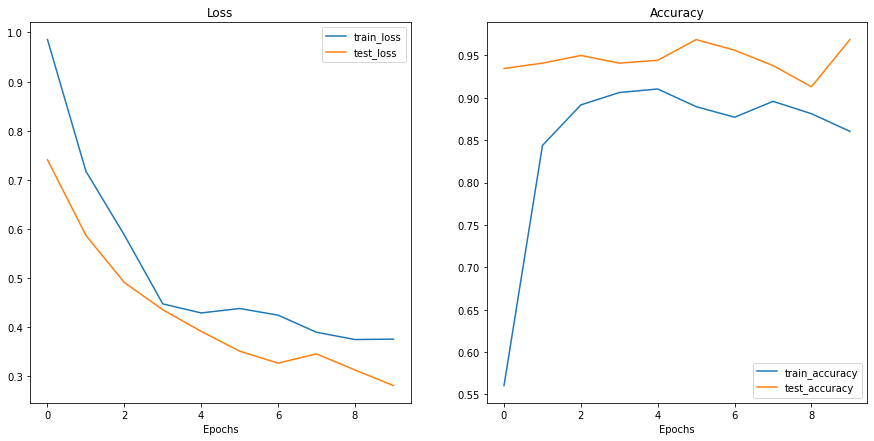

In [14]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

Woah!

Those are some nice looking loss curves. 

It looks like our model is performing quite well and perhaps would benefit from a little longer training and potentially some [data augmentation](https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation) (to help prevent overfitting occurring from longer training).

### TK - Saving EffNetB2

Now we've got a well-performing trained model, let's save it to file so we can import and use it later.

To save our model we can use the `utils.save_model()` function we created in [05. PyTorch Going Modular section 5](https://www.learnpytorch.io/05_pytorch_going_modular/#5-creating-a-function-to-save-the-model-utilspy).

We'll set the `target_dir` to `"models"` and the `model_name` to `"09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"` (a little comprehensive but at least we know what's going on).

In [15]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### TK - Checking the size of EffNetB2

Since one of our criteria for deploying a model to power FoodVision Mini is **speed** (~30FPS or better), let's check the size of our model.

Why check the size?

Well, while not always the case, the size of a model can influence its inference speed.

As in, if a model has more parameters, it generally performs more operations and each one of these operations requires some computing power.

And because we'd like our model to work on devices with limited computing power (e.g. on a mobile device or in a web browser), generally, the smaller the size the better (as long as it still performs well in terms of accuracy).

To check our model's size in bytes, we can use `pathlib.Path.stat("path_to_model").st_size` and then we can convert it (roughly) to megabytes by dividing it by `(1024*1024)`. 

In [16]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


### TK - Collecting EffNetB2 stats

We've got a few statistics about our EffNetB2 model such as test loss, test accuracy and model size, how about we collect them all in a dictionary so we can compare them to the upcoming ViT feature extractor.

And we'll calculate an extra one for fun, total number of parameters.

We can do so by counting the number of elements (or patterns/weights) in `effnetb2.parameters()`. We'll access the number of elements in each parameter using the [`torch.numel()`](https://pytorch.org/docs/stable/generated/torch.numel.html) (short for "number of elements") method. 

In [17]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

Excellent!

Now let's put everything in a dictionary so we can make comparisons later on.

In [18]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.281286683678627,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

Epic! Looks like our EffNetB2 model is performing at over 95% accuracy! Criteria number 1: perform at 95%+ accuracy, tick!

## TK - Creating a ViT feature extractor

Time to continue with our FoodVision Mini modelling experiments.

This time we're going to create a ViT feature extractor.

And we'll do it in much the same way as the EffNetB2 feature extractor except this time with [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16) instead of `torchvision.models.efficientnet_b2()`.

We'll start by creating a function called `create_vit_model()` which will be very similar to `create_effnetb2_model()` except of course returning a ViT feature extractor model and transforms rather than EffNetB2.

Another slight difference is that `torchvision.models.vit_b_16()`'s output layer is called `heads` rather than `classifier`.

In [19]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

Knowing this, we've got all the pieces of the puzzle we need.

In [20]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

ViT feature extraction model creation function ready!

Let's test it out.

In [21]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

No errors, lovely to see! 

Now let's get a nice-looking summary of our ViT model using `torchinfo.summary()`.

In [22]:
from torchinfo import summary
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                                  [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                                   [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                                    [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                               [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                             [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                             [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─Encod

TK image - summary output

Just like our EffNetB2 feature extractor model, our ViT model's base layers are frozen and the output layer is customized to our needs! 

Do you notice the big difference though?

Our ViT model has *far* more parameters than our EffNetB2 model. Perhaps this will come into play when we compare are our models across speed and performance later on.

### TK - Create DataLoaders for ViT

We've got our ViT model ready, now let's create some `DataLoader`s for it.

We'll do this in the same way we did for EffNetB2 except we'll use `vit_transforms` to transform our images into the same format the ViT model was trained on. 

In [23]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

### TK - Training ViT

You know what time it is...

...it's traininggggggg time (sung in the same tune as the song [Closing Time](https://youtu.be/xGytDsqkQY8)). 

Let's train our ViT feature extractor model for 10 epochs using our `engine.train()` function with `torch.optim.Adam()` and a learning rate of `1e-3` as our optimizer and `torch.nn.CrossEntropyLoss()` as our loss function.

We'll use our `set_seeds()` function before training to try and make our results as reproducible as possible. 

In [24]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


### TK - Inspecting ViT loss curves

Alright, alright, alright, ViT model trained, let's get visual and see some loss curves.

> **Note:** Don't forget you can see what an ideal set of loss curves should look like in [04. PyTorch Custom Datasets section 8](https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like).

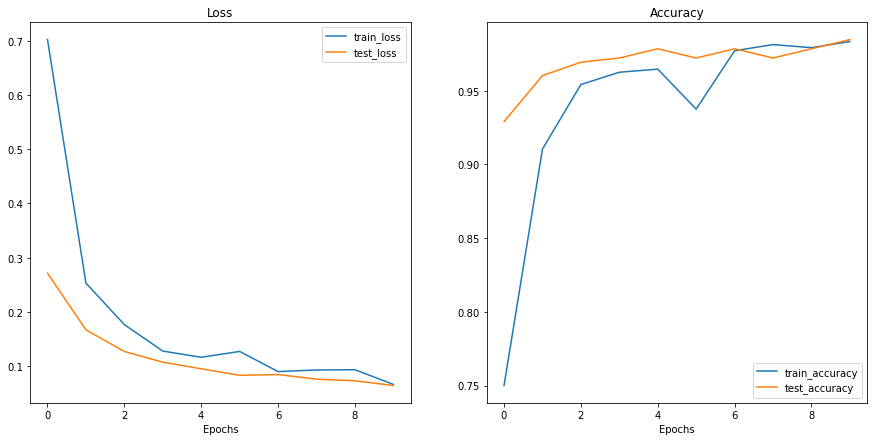

In [25]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

Ohh yeah! 

Those are some nice looking loss curves. Just like our EffNetB2 feature extractor model, it looks our ViT model might benefit from a little longer training time and perhaps some [data augmentation](https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation) (to help prevent overfitting). 

### TK - Saving ViT

Our ViT model is performing outstanding! 

So let's save it to file so we can import it and use it later if we wish.

We can do so using the `utils.save_model()` function we created in [05. PyTorch Going Modular section 5](https://www.learnpytorch.io/05_pytorch_going_modular/#5-creating-a-function-to-save-the-model-utilspy). 

In [26]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### TK - Checking the size of ViT

And since we want to compare our EffNetB2 model to our ViT model across a number of characteristics, let's find out its size.

To check our model's size in bytes, we can use Python's `pathlib.Path.stat("path_to_model").st_size` and then we can convert it (roughly) to megabytes by dividing it by `(1024*1024)`. 

In [27]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


Hmm, how does the ViT feature extractor model size compare to our EffNetB2 model size?

We'll find this out shortly when we compare all of our model's characteristics.

### TK - Collecting ViT stats

Let's put together all of our ViT model statistics.

We saw it in the summary output above but we'll calculate its total number of parameters. 

In [28]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

Woah, that looks like a fair bit more than our EffNetB2!

> **Note:** A larger number of parameters (or weights/patterns) generally means a model has a higher *capacity* to learn, whether it actually uses this extra capacity is another story. In light of this, our EffNetB2 model has 7,705,221 parameters where as our ViT model has 85,800,963 (11.1x more) so we could assume that our ViT model has more of a capacity to learn, if given more data (more opportunities to learn). However, this larger capacity to learn ofen comes with an  increased model filesize and a longer time to perform inference.

Now let's create a dictionary with some important characteristics of our ViT model.

In [29]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06418213145807386,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

Nice! Looks like our ViT model achieves over 95% accuracy too.

## TK - Making predictions with our trained models and timing them

We've got a couple of trained models, both performing pretty well.

Now how about we test them out doing what we'd like them to do?

As in, let's see how they go making predictions (performing inference).

We know both of our models are performing at over 95% accuracy, but how fast are they?

Ideally, if we're deploying our FoodVision Mini model to a mobile device so people can take photos of their food and identify it, we'd like the predictions to happen at real-time (~30 frames per second).

That's why our second criteria is: a fast model.

To find out how long each of our models take to performance inference, let's create a function called `pred_and_store()` to iterate over each of the test dataset images one by one and perform a prediction. 

We'll time each of the predictions as well as store the results in a common prediction format: a list of dictionaries (where each single prediction is its own dictionary). 

> **Note:** We time the predictions one by one rather than by batch because when our model is deployed, it will likely only be making a prediction on one image at a time. As in, someone takes a photo and our model predicts on that single image.

Since we'd like to make predictions across all the images in the test set, let's first get a list of all of the test image paths so we can iterate over them. 

To do so, we'll use Python's `pathlib.Path("target_dir").glob("*/*.jpg"))` to find all of the filepaths in a target directory with the extension `.jpg` (all of our test images).

In [30]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/831681.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2752603.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/39461.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/730464.jpg')]

### TK - Creating a function to make predictions across the test dataset

Now we've got a list of our test image paths, let's get to work on our `pred_and_store()` function:

1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms (to prepare images), a list of target class names and a target device.
2. Create an empty list to store prediction dictionaries (we want the function to return a list of dictionaries, one for each prediction).
3. Loop through the target input paths (steps 4-14 will happen inside the loop).
4. Create an empty dictionary for each iteration in the loop to store prediction values per sample.
5. Get the sample path and ground truth class name (we can do this by infering the class from the path).
6. Start the prediction timer using Python's `timeit.default_timer`.
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image so it's capable of being using with the target model as well as add a batch dimension and send the image to the target device.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and calculate the prediction probability using `torch.softmax()` and the target label using `torch.argmax()`.
11. Add the prediction probability and prediction class to the prediction dictionary created in step 4. Also make sure the prediction probability is on the CPU so it can be used with non-GPU libraries such as NumPy and pandas for later inspection.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary created in step 4.
13. See if the predicted class matches the ground truth class from step 5 and add the result to the prediction dictionary created in step 4.
14. Append the updated prediction dictionary to the empty list of predictions created in step 2.
15. Return the list of prediction dictionaries.

A bunch of steps, but nothing we can't handle!

Let's do it.

In [31]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaires
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

Ho, ho! 

What a good looking function!

And you know what, since our `pred_and_store()` is a pretty good utility function for making and storing predictions, it could be stored to [`going_modular.going_modular.predictions.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/predictions.py) for later use. That might be an extension you'd like to try, check out [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/) for ideas.

### TK - Making and timing predictions with EffNetB2

Time to test out our `pred_and_store()` function!

Let's start by using it to make predictions across the test dataset with our EffNetB2 model, paying attention to two details:

1. **Device** - We'll hard code the `device` parameter to use `"cpu"` because when we deploy our model, we won't always have access to a `"cuda"` (GPU) device.
    * Making the predictions on CPU will be a good indicator of speed of inference too because generally predictions on CPU devices are slower than GPU devices.
2. **Transforms** - We'll also be sure to set the `transform` parameter to `effnetb2_transforms` to make sure the images are opened and transformed in the same way our `effnetb2` model has been trained on. 

In [32]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU 

  0%|          | 0/150 [00:00<?, ?it/s]

Nice! Look at those predictions fly!

Let's inspect the first couple and see what they look like.

In [33]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/831681.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9293,
  'pred_class': 'steak',
  'time_for_pred': 0.0574,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9534,
  'pred_class': 'steak',
  'time_for_pred': 0.0326,
  'correct': True}]

Woohoo!

It looks like our `pred_and_store()` function worked nicely.

Thanks to our list of dictionaries data structure, we've got plenty of useful information we can further inspect.

To do so, let's turn our list of dictionaries into a pandas DataFrame.

In [34]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.9293,steak,0.0574,True
1,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9534,steak,0.0326,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.7531,steak,0.0313,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.5935,steak,0.0320,True
4,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.8959,steak,0.0328,True


Beautiful!

Look how easily those prediction dictionaries turn into a structured format we can perform analysis on.

Such as finding how many predictions our EffNetB2 model got wrong...

In [35]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     145
False      5
Name: correct, dtype: int64

Five wrong predictions out of 150 total, not bad!

And how about the average prediction time?

In [36]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.0298 seconds


Hmm, how does that average prediction time live up to our criteria of our model performing at real-time (~30FPS or 0.03 seconds per prediction)?

> **Note:** Prediction times will be different across different hardware types (e.g. a local Intel i9 vs Google Colab CPU). The better and faster the hardware, generally, the faster the prediction. For example, on my local deep learning PC with an Intel i9 chip, my average prediction time with EffNetB2 is around 0.031 seconds (just under real-time). However, on Google Colab (I'm not sure what CPU hardware Colab uses but it looks like it might be an [Intel(R) Xeon(R)](https://stackoverflow.com/questions/47805170/whats-the-hardware-spec-for-google-colaboratory)), my average prediction time with EffNetB2 is about 0.1396 seconds (3-4x slower).

Let's add our EffNetB2 average time per prediction to our `effnetb2_stats` dictionary.

In [37]:
# Add EffNetB2 average prediction time to stats dictionary 
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.281286683678627,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.0298}

### TK - Making and timing predictions with ViT 

We've made predictions with our EffNetB2 model, now let's do the same for our ViT model.

To do so, we can use the `pred_and_store()` function we created above except this time we'll pass in our `vit` model as well as the `vit_transforms`.

And we'll keep the predictions on the CPU via `device="cpu"` (a natural extension here would be to test the prediction times on CPU and on GPU).

In [38]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

Predictions made!

Now let's check out the first couple.

In [39]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/831681.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9933,
  'pred_class': 'steak',
  'time_for_pred': 0.1304,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9893,
  'pred_class': 'steak',
  'time_for_pred': 0.0654,
  'correct': True}]

Wonderful!

And just like before, since our ViT model's predictions are in the form of a list of dictionaries, we can easily turn them into a pandas DataFrame for further inspection. 

In [40]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.9933,steak,0.1304,True
1,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9893,steak,0.0654,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9971,steak,0.0642,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.7685,steak,0.0649,True
4,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9499,steak,0.0658,True


How many predictions did our ViT model get correct?

In [41]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

Woah!

Our ViT model did a little better than our EffNetB2 model in terms of correct predictions, only two samples wrong across the whole test dataset.

As an extension you might want to visualize the ViT model's wrong predictions and see if there's any reason why it might've got them wrong.

How about we calculate how long the ViT model took per prediction?

In [42]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.0679 seconds


Well, that looks a little slower than our EffNetB2 model's average time per prediction but how does it look in terms of our second criteria: speed?

For now, let's add the value to our `vit_stats` dictionary so we can compare it to our EffNetB2 model's stats.

> **Note:** The average time per prediction values will be highly dependent on the hardware you make them on. For example, for the ViT model, my average time per prediction (on the CPU) was 0.0693-0.0777 seconds on my local deep learning PC with an Intel i9 CPU. Where as on Google Colab, my average time per prediction with the ViT model was 0.6766-0.7113 seconds.

In [43]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06418213145807386,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.0679}

## TK - Comparing model results, prediction times and size

Our two best model contenders have been trained and evaluated.

Now let's put them head to head and compare across their different statistics.

To do so, let's turn our `effnetb2_stats` and `vit_stats` dictionaries into a pandas DataFrame.

We'll add a column to view the model names as well as the convert the test accuracy to a whole percentage rather than decimal.

In [44]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281287,96.88,7705221,29,0.0298,EffNetB2
1,0.064182,98.47,85800963,327,0.0679,ViT


Wonderful!

It seems our models are quite close in terms of overall test accuracy but how do they look across the other fields?

One way to find out would be to divide the ViT model statistics by the EffNetB2 model statistics to find out the different ratios between the models.

Let's create another DataFrame to do so.

In [45]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.228173,1.016412,11.135432,11.275862,2.278523


It seems our ViT model outperforms the EffNetB2 model across the performance metrics (test loss, where lower is better and test accuracy, where higher is better) but at the expense of having:
* 11x+ the number of parameters.
* 11x+ the model size. 
* 2.5x+ the prediction time per image.

Are these tradeoffs worth it?

Perhaps if we had unlimited compute power but for our use case of deploying the FoodVision Mini model to a smaller device (e.g. a mobile phone), we'd likely start out with the EffNetB2 model for faster predictions at a slightly reduced performance but dramatically smaller 

### TK - Visualizing the speed vs. performance tradeoff 

We've seen that our ViT model outperforms our EffNetB2 model in terms of performance metrics such as test loss and test accuracy.

However, our EffNetB2 model makes performs predictions faster and has a much small model size.

> **Note:** Performance or inference time is also often referred to as "latency".

How about we make this fact visual?

We can do so by creating a plot with matplotlib:
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT `time_per_pred_cpu` and `test_acc` values.
2. Add titles and labels respective of the data and customize the fontsize for aesthetics.
3. Annotate the samples on the scatter plot from step 1 with their appropriate labels (the model names).
4. Create a legend based on the model sizes (`model_size (MB)`). 

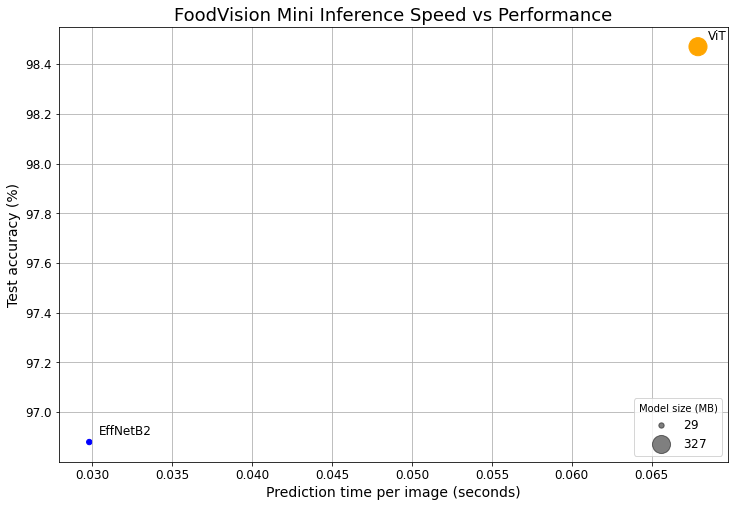

In [46]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)
    
plt.show()

Woah!

The plot really visualizes the **speed vs. performance tradeoff**, in other words, when you have a larger, better performing deep model (like our ViT model), it *generally* takes longer to perform inference.

There are exceptions to the rule and new research is being published all the time to help make larger models perform faster.

And it can be tempting to just deploy the *best* performing model but it's also good to take into considersation where the model is going to be performing.

In our case, the differences between our model's performance levels (on the test loss and test accuracy) aren't too extreme.

But since we'd like to put an emphasis on speed to begin with, we're going to stick with deploying EffNetB2 since it's faster and has a much smaller footprint.

> **Note:** Prediction times will be different across different hardware types (e.g. Intel i9 vs Google Colab CPU vs GPU) so it's important to think about and test where your model is going to end up. Asking questions like "where is the model going to be run?" or "what is the ideal scenario for running the model?" and then running experiments to try and provide answers on your way to deployment is very helpful. 

## TK - Bringing FoodVision Mini to life by creating a Gradio demo

We've decided we'd like to deploy the EffNetB2 model (to begin with, this could always be changed later).

So how can we do that?

There are several ways to deploy a machine learning model each with specific use cases (as discussed above).

We're going to be focused on perhaps the quickest and certainly one of the most fun ways to get a model deployed to the internet.

And that's by using [Gradio](https://gradio.app/).

What's Gradio?

The homepage describes it beautifully: 

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!

Why create a demo of your models?

Because metrics on the test set look nice but you never really know how you're model performs until you use it in the wild.

So let's get deploying!

We'll start by importing Gradio with the common alias `gr` and if it's not present, we'll install it.

In [47]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

Gradio version: 3.1.4


Gradio ready!

Let's turn FoodVision Mini into a demo application.

### TK - Gradio overview

The overall premise of Gradio is very similar to what we've been repeating throughout the course.

What are our **inputs** and **outputs**?

And how should we get there?

Well that's what our machine learning model does.

```
inputs -> ML model -> outputs
```

In our case, for FoodVision Mini, our inputs are images of food, our ML model is EffNetB2 and our outputs are classes of food (pizza, steak or sushi).

```
images of food -> EffNetB2 -> outputs
```

Though the concepts of inputs and outputs can be bridged to almost any other kind of ML problem.

Your inputs and outputs might be any combination of the following:
* Images
* Text
* Video
* Tabular data
* Audio
* Numbers
* & more

And the ML model you build will depend on your inputs and outputs.

Gradio emulates this paradigm by creating an interface ([`gradio.Interface()`](https://gradio.app/docs/#interface-header)) to from inputs to outputs.

```
gradio.Interface(fn, inputs, outputs)
```

Where, `fn` is a Python function to map the `inputs` to the `outputs`.

TK image - Gradio: inputs -> fn -> outputs

> **Note:** Gradio has a vast number of possible `inputs` and `outputs` options known as "Components" from images to text to numbers to audio to videos and more. You can see all of these in the [Gradio Components documentation](https://gradio.app/docs/#components).

### TK - Creating a function to map our inputs and outputs

To create our FoodVision Mini demo with Gradio, we'll need a function to map our inputs to our outputs.

We created a function earlier called `pred_and_store()` to make predictions with a given model across a list of target files and store them in a list of dictionaries.

How about we create a similar function but this time focusing on a making a prediction on a single image with our EffNetB2 model?

More specifically, we want a function that takes an image as input, preprocesses (transforms) it, makes a prediction with EffNetB2 and then returns the prediction (pred or pred label for short) as well as the prediction probability (pred prob).

And while we're here, let's return the time it took to do so too:

```
input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken
```

This will be our `fn` parameter for our Gradio interface.

First, let's make sure our EffNetB2 model is on the CPU (since we're sticking with CPU-only predictions, however you could change this if you have access to a GPU).

In [48]:
# Put EffNetB2 on CPU
effnetb2.to("cpu") 

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

And now let's create a function called `predict()` to replicate the workflow above.

In [49]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

Beautiful! 

Now let's see our function in action by performing a prediction on a random image from the test dataset.

We'll start by getting a list of all the image paths from the test directory and then randomly selecting one.

Then we'll open the randomly selected image with `PIL.Image.open()`.

Finally, we'll pass the image to our `predict()` function.

In [50]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/1972463.jpg

Prediction label and probability dictionary: 
{'pizza': 0.05136595293879509, 'steak': 0.6942882537841797, 'sushi': 0.25434577465057373}
Prediction time: 0.02819 seconds


Nice!

Running the cell above a few times we can see different prediction probabilities for each label from our EffNetB2 model as well as the time it took per prediction.

### TK - Creating a list of example images

Our `predict()` function enables us to go from inputs -> transform -> ML model -> outputs.

Which is exactly what we need for our Graido demo.

But before we create the demo, let's create one more thing: a list of examples.

Gradio's interface class takes a list of examples of as an optional parameter (`gradio.Interface(examples=List[Any])`).

And the format for the `examples` parameter is a list of lists.

So let's create a list of lists containing random filepaths to our test images.

Three examples should be enough.

In [51]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/3785667.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/2416569.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/2307638.jpg']]

Perfect!

Our Gradio demo will showcase these as example inputs to our demo so people can try it out and see what it does without uploading any of their own data. 

### TK - Building a Gradio interface

Time to put everything together and bring our FoodVision Mini demo to life!

Let's create a Gradio interface to replicate the workflow:

```
input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken
```

We can do with the [`gradio.Interface()`](https://gradio.app/docs/#interface) class with the following parameters:
* `fn` - a Python function to map `inputs` to `outputs`, in our case, we'll use our `predict()` function.
* `inputs` - the input to our interface, such as an image using [`gradio.Image()`](https://gradio.app/docs/#image) or `"image"`. 
* `outputs` - the output of our interface once the `inputs` have gone through the `fn`, such as a label using [`gradio.Label()`](https://gradio.app/docs/#label) (for our model's predicted labels) or number using [`gradio.Number()`](https://gradio.app/docs/#number) (for our model's prediction time).
    * **Note:** Gradio comes with many in-built `inputs` and `outputs` options known as ["Components"](https://gradio.app/docs/#components).
* `examples` - a list of examples to showcase for the demo.
* `title` - a string title of the demo.
* `description` - a string description of the demo.
* `article` - a reference note at the bottom of the demo.

Once we've created our demo instance of `gr.Interface()`, we can bring it to life using [`gradio.Interface().launch()`](https://gradio.app/docs/#launch-header) or `demo.launch()` command. 

Easy!

In [52]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://47231.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f52617071c0>,
 'http://127.0.0.1:7860/',
 'https://47231.gradio.app')

TK image - gif of Gradio demo working in Google Colab, show the link to the demo as well 

Woohoo!!! What an epic demo!!!

FoodVision Mini has officially come to life in an interface someone could use and try out.

If you set `share=True` in the `launch()` method, Gradio also provides you with a shareable link such as `https://28176.gradio.app` which is valid for 72-hours.

The link provides a proxy back to the Gradio interface you launched.

For more permanent hosting, you can upload your Gradio app to [Hugging Face Spaces](https://huggingface.co/spaces) or anywhere that runs Python code.

## TK - Turning our FoodVision Mini Gradio Demo into a deployable app

We've seen our FoodVision Mini model come to life through a Gradio demo.

But what if we wanted to share it with our friends?

Well, we could use the provided Gradio link, however, the shared link only lasts for 72-hours.

To make our FoodVision Mini demo more permanent, we can packaged it into an app and upload it to [Hugging Face Spaces](https://huggingface.co/spaces/launch).

### TK What is Hugging Face Spaces?

Hugging Face Spaces is a resource that allows you to host and share machine learning apps.

Building a demo is one of the best ways to showcase and test what you've done.

And Spaces allows you to do just that.

You can think of Hugging Face as the GitHub of machine learning.

If having a good GitHub portfolio showcases your coding abilities, having a good Hugging Face portfolio can showcase your machine learning abilities.

> **Note:** There are many other places we could upload and host our Gradio app such as, Google Cloud, AWS (Amazon Web Services) or other cloud vendors, however, we're going to use Hugging Face Spaces due to the ease of use and wide adoption by the machine learning community.

### TK - Deployed Gradio app structure overview

To upload our demo Gradio app, we'll want to put everything relating to it into a single directory.

For example, our demo might live at the path `demos/foodvision_mini/` with the file structure:

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

Where:
* `09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth` is our trained PyTorch model file.
* `app.py` contains our Gradio app (similar to the code that launched the app).
    * **Note:** `app.py` is the default filename used for Hugging Face Spaces, if you deploy your app there, Spaces will by default look for a file called `app.py` to run. This is changable in settings.
* `examples/` contains example images to use with our Gradio app.
* `model.py` contains the model defintion as well as any transforms assosciated with the model.
* `requirements.txt` contains the dependencies to run our app such as `torch`, `torchvision` and `gradio`.

Why this way?

Because it's one of the simplest layouts we could begin with. 

Our focus is: *experiment, experiment, experiment!* 

The quicker we can run smaller experiments, the better our bigger ones will be.

We're going to work towards recreating the structure above but you can see a live demo app running on Hugging Face Spaces as well as the file structure:
* [Live Gradio demo of FoodVision Mini 🍕🥩🍣](https://huggingface.co/spaces/mrdbourke/foodvision_mini).
* [FoodVision Mini file structure on Hugging Face Spaces](https://huggingface.co/spaces/mrdbourke/foodvision_mini/tree/main).

### TK - Creating a `demos` folder to store our FoodVision Mini app files

To begin, let's first create a `demos/` directory to store all of our FoodVision Mini app files.

We can do with Python's [`pathlib.Path("path_to_dir")`](https://docs.python.org/3/library/pathlib.html#basic-use) to establish the directory path and [`pathlib.Path("path_to_dir").mkdir()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir) to create it. 

In [53]:
import shutil
from pathlib import Path


# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    foodvision_mini_demo_path.mkdir(parents=True, 
                                    exist_ok=True)
    
!ls demos/foodvision_mini/

### TK - Creating a folder of example images to use with our FoodVision Mini demo

Now we've got a directory to store our FoodVision Mini demo files, let's add some examples to it.

Three example images from the test dataset should be enough.

To do so we'll:
1. Create an `examples/` directory within the `demos/foodvision_mini` directory.
2. Choose three random images from the test dataset and collect their filepaths in a list.
3. Copy the three random images from the test dataset to the `demos/foodvision_mini/examples/` directory.

In [54]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


Now to verify our examples are present, let's list the contents of our `demos/foodvision_mini/examples/` directory with `os.listdir()` and then format the filepaths into a list of lists (so it's compatible with Gradio's [`gradio.Interface()`](https://gradio.app/docs/#interface) `example` parameter).

In [55]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/3622237.jpg'], ['examples/592799.jpg'], ['examples/2582289.jpg']]

### TK - Moving our trained EffNetB2 model to our FoodVision Mini demo directory

We previously saved our FoodVision Mini EffNetB2 feature extractor model under `models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth`.

And rather double up on saved model files, let's move our model to our `demos/foodvision_mini` directory.

We can do so using Python's `shutil.move()` method and passing in `src` (the source path of the target file) and `dst` (the destination path of the target file to be moved to) parameters. 

In [56]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model 
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
    
    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path, 
                dst=effnetb2_foodvision_mini_model_destination)
    
    print(f"[INFO] Model move complete.")
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### TK - Turning our EffNetB2 model into a Python script (`model.py`)

Our current model's `state_dict` is saved to `demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth`.

To load it in we can use `model.load_state_dict()` along with `torch.load()`.

> **Note:** For a refresh on saving and loading a model (or a model's `state_dict` in PyTorch, see [01. PyTorch Workflow Fundamentals section 5: Saving and loading a PyTorch model](https://www.learnpytorch.io/01_pytorch_workflow/#5-saving-and-loading-a-pytorch-model) or see the PyTorch recipe for [What is a `state_dict` in PyTorch?](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)

But before we can do this, we first need a way to instantiate a `model`.

To do this in a modular fashion we'll create a script called `model.py` which contains our `create_effnetb2_model()` function (TK - where was this function created?).

That way we can import the function in *another* script (see `app.py` below) and then use it to create our EffNetB2 `model` instance as well as get its appropriate transforms.

Just like in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/), we'll use the `%%writefile path/to/file` magic command to turn a cell of code into a file.

In [57]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/foodvision_mini/model.py


### TK - Turning our FoodVision Mini Gradio app into a Python script (`app.py`)

We've now got a `model.py` script as well as a path to a saved model `state_dict` that we can load in.

Time to construct `app.py`.

Our `app.py` script will put together all of the pieces of the puzzle to create our Gradio demo.

We call it `app.py` because by default when you create a HuggingFace Space, it looks for a file called `app.py` to run and host (though you can change this in settings).

Our `app.py` script will have four main parts:
1. **Imports and class names setup** - Here we'll import the various dependencies for our demo including the `create_effnetb2_model()` function from `model.py` as well as setup the different class names for our FoodVision Mini app. 
2. **Model and transforms preparation** - Here we'll create an EffNetB2 model instance along with the transforms to go with it and then we'll load in the saved model weights/`state_dict`. When we load the model we'll also set `map_location=torch.device("cpu")` in [`torch.load()`](https://pytorch.org/docs/stable/generated/torch.load.html) so our model gets loaded onto the CPU regardless of the device it trained on (we do this because we won't necessarily have a GPU when we deploy and we'll get an error if our model is trained on GPU but we try to deploy it to CPU without explicitly saying so).
3. **Predict function** - Gradio's `gradio.Interface()` takes a `fn` parameter to map inputs to outputs, our `predict()` function will be the same as the one we defined above (TK - what section did predict function come from?), it will take in an image and then use the loaded transforms to preprocess it before using the loaded model to make a prediction on it.
    * **Note:** We'll have to create the example list on the fly via the `examples` parameter. We can do so by creating a list of the files inside the `examples/` directory with: `[["examples/" + example] for example in os.listdir("examples")]`.
4. **Gradio app** - This is where the main logic of our demo will live, we'll create a `gradio.Interface()` instance called `demo` to put together our inputs, `predict()` function and outputs. And we'll finish the script by calling `demo.launch()` to launch our FoodVision Mini demo!

In [58]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


### TK - Creating a requirements file for FoodVision Mini (`requirements.txt`)

The last file we need to create for our FoodVision Mini app is a [`requirements.txt` file](https://learnpython.com/blog/python-requirements-file/).

This will be a text file containing all of the required dependencies for our demo.

When we deploy our demo app to Hugging Face Spaces, it will search through this file and install the dependencies we define so our app can run.

The good news is, there's only three!

1. `torch==1.12.0`
2. `torchvision==0.13.0`
3. `gradio==3.1.4`

The `==1.12.0` states the version number to install.

Defining the version number is not 100% required but we will for now so if any breaking updates occur in future releases, our app still runs (PS if you find any errors, feel free to post on the course [GitHub Issues](https://github.com/mrdbourke/pytorch-deep-learning/issues)).

In [59]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


Nice!

We've officially got all the files we need to deploy our FoodVision Mini demo!

## TK - Deploying our FoodVision Mini app to HuggingFace Spaces

We've got a file containing our FoodVision Mini demo, now how do we get it to run on Hugging Face Spaces?

There are two main options for uploading to a Hugging Face Space (also called a [Hugging Face Repository](https://huggingface.co/docs/hub/repositories-getting-started#getting-started-with-repositories), similar to a git repository): 
1. [Uploading via the Hugging Face Web interface (easiest)](https://huggingface.co/docs/hub/repositories-getting-started#adding-files-to-a-repository-web-ui).
2. [Uploading via the command line or terminal](https://huggingface.co/docs/hub/repositories-getting-started#terminal).
    * **Bonus:** You can also use the [`huggingface_hub` library](https://huggingface.co/docs/huggingface_hub/index) to interact with Hugging Face, this would be a good extension to the above two options.

Feel free to read the documentation on both options but we're going to go with option two.

> **Note:** To host anything on Hugging Face, you will to [sign up for a free Hugging Face account](https://huggingface.co/join). 

### TK - Downloading our FoodVision Mini app files

Let's check out the demo files we've got inside `demos/foodvision_mini`.

To do so we can use the `!ls` command followed by the target filepath.

`ls` stands for "list" and the `!` means we want to execute the command at the shell level.

In [60]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
app.py
examples
model.py
requirements.txt


These are all files that we've created!

To begin uploading our files to Hugging Face, let's now download them from Google Colab (or wherever you're running this notebook).

To do so, we'll first compress the files into a single zip folder via the command: 

```
zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"
```

Where: 
* `zip` stands for "zip" as in "please zip together the files in the following directory". 
* `-r` stands for "recursive" as in, "go through all of the files in the target directory".
* `../foodvision_mini.zip` is the target directory we'd like our files to be zipped to.
* `*` stands for "all the files in the current directory".
* `-x` stands for "exclude these files". 

We can download our zip file from Google Colab using `google.colab.files.download("demos/foodvision_mini.zip")` (we'll put this inside a `try` and `except` block just in case we're not running the code inside Google Colab, and if so we'll print a message saying to manually download the files).

Let's try it out!

In [61]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

updating: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
updating: app.py (deflated 57%)
updating: examples/ (stored 0%)
updating: examples/3622237.jpg (deflated 0%)
updating: examples/592799.jpg (deflated 1%)
updating: examples/2582289.jpg (deflated 17%)
updating: model.py (deflated 56%)
updating: requirements.txt (deflated 4%)
Not running in Google Colab, can't use google.colab.files.download(), please manually download.


Woohoo!

Looks like our `zip` command was successful.

If you're running this notebook in Google Colab, you should see a file start to download in your browser.

Otherwise, you can see the `foodvision_mini.zip` folder (and more) on the [course GitHub under the `demos/` directory](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/demos). 

### TK - Running our FoodVision Mini demo locally

If you download the `foodvision_mini.zip` file, you can test it locally by:
1. Unzipping the file.
2. Opening terminal or a command line prompt.
3. Changing into the `foodvision_mini` directory (`cd foodvision_mini`).
4. Installing the requirements (`pip install requirements.txt`).
5. Run the app (`python app.py`).

This should result in a Gradio demo just like the one we built above running locally on your machine.

> **Note:** If you run the app locally and you notice a `flagged/` directory appear, it contains samples that have been "flagged". 
>
> For example, if someone tries the demo and the model produces an incorrect result, the sample can be "flagged" and reviewed for later.
> 
> For more on flagging in Gradio, see the [flagging documentation](https://gradio.app/docs/#flagging).

TK image - gif of the above workflow: Google Colab -> Download `foodvision_mini.zip` -> unzip -> install dependencies -> run locally 

### TK - Uploading to Hugging Face

We've verfied our FoodVision Mini app works locally, however, the fun of creating a machine learning demo is to show it to other people and allow them to use it.

To do so, we're going to upload our FoodVision Mini demo to Hugging Face. 

> **Note:** The following series of steps uses a Git (a file tracking system) workflow. For more on how Git works, I'd recommend going through the [Git and GitHub for Beginners tutorial](https://youtu.be/RGOj5yH7evk) on freeCodeCamp.

1. [Sign up](https://huggingface.co/join) for a Hugging Face account. 
2. Start a new Hugging Face Space by going to your profile and then [clicking "New Space"](https://huggingface.co/new-space).
    * **Note:** A Space in Hugging Face is also known as a "code repository" (a place to store your code/files) or "repo" for short.
3. Give the Space a name, for example, mine is called `mrdbourke/foodvision_mini`, you can see it here: https://huggingface.co/spaces/mrdbourke/foodvision_mini
4. Select a license (I used [MIT](https://opensource.org/licenses/MIT)).
5. Select Gradio as the Space SDK (software development kit). 
   * **Note:** You can use other options such as Streamlit but since our app is built with Gradio, we'll stick with that.
6. Choose whether your Space is it's public or private (I selected public since I'd like my Space to be available to others).
7. Click "Create Space".
8. Clone the repo locally by running something like: `git clone https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME]` in terminal or command prompt.
    * **Note:** You can also add files via uploading them under the "Files and versions" tab.
9. Copy/move the contents of the downloaded `foodvision_mini` folder to the cloned repo folder.
10. To upload and track larger files (e.g. files over 10MB or in our case, our PyTorch model file) you'll need to [install Git LFS](https://git-lfs.github.com/) (which stands for "git large file storage").
11. After you've installed Git LFS, you can activate it by running `git lfs install`.
12. In the `foodvision_mini`, track the files over 10MB with Git LFS with `git lfs track "*.file_extension"`.
    * To track our EffNetB2 PyTorch model you can run `git lfs track "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"`.
13. Track `.gitattributes` (automatically created when cloning from HuggingFace) using `git add .gitattributes` (this file will help ensure our larger files are tracked with Git LFS).
    * You can see an example `.gitattributes` file at https://huggingface.co/spaces/mrdbourke/foodvision_mini/blob/main/.gitattributes 
14. Add the rest of the `foodvision_mini` app files and commit them with: 
    * `git add *`.
    * `git commit -m "first commit"`.
15. Push (upload) the files to Hugging Face:
    * `git push`.
16. Wait 3-5 minutes for the build to happen (future builds are faster) and your app to become live!

If everything worked, you should see a live running example of our FoodVision Mini Gradio demo like the one here: https://huggingface.co/spaces/mrdbourke/foodvision_mini 

* TK image - gif of the above workflow from Google Colab -> Hugging Face Space
* TK explain embedding as iFrame - https://gradio.app/sharing_your_app/

In [95]:
from IPython.display import IFrame

IFrame(src="https://hf.space/embed/mrdbourke/foodvision_mini/+", width=900, height=750)

## TK - Creating FoodVision Big

We've spent the past few sections and chapters working on bringing FoodVision Mini to life.

And now we've seen it working in a live demo, how about we step things up a notch?

How?

FoodVision Big!

Since FoodVision Mini is trained on pizza, steak and sushi images from the [Food101 dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) (101 classes of food x 1000 images each), how about we make FoodVision Big by training a model on all 101 classes!

We'll go from three classes to 101!

From pizza, steak, sushi to pizza, steak, sushi, hot dog, apple pie, carrot cake, chocolate cake, french fires, garlic bread, ramen, nachos, tacos and more!

How?

Well, we've got all the steps in place, all we have to do is alter our EffNetB2 model slightly as well as prepare a different dataset.

To finish Milestone Project 3, let's recreate a Gradio demo similar to FoodVision Mini (three classes) but for FoodVision Big (101 classes).

TK image - FoodVision Mini -> FoodVision Big

### TK - Creating a model and transforms for FoodVision Big

When creating FoodVision Mini we saw that the EffNetB2 model was a good tradeoff between speed and performance (it performed well with a fast speed).

So we'll continue using the same model for FoodVision Big.

We can create an EffNetB2 feature extractor for Food101 by using our `create_effnetb2_model()` function we created above (TK - what section?) and passing it the parameter `num_classes=101` (since Food101 has 101 classes).

In [62]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

Beautiful!

Let's now get a summary of our model.

In [63]:
# Get a summary of EffNetB2 feature extractor for Food101
from torchinfo import summary
summary(effnetb2_food101, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

TK image - turn summary into image

Nice!

See how just like our EffNetB2 model for FoodVision Mini the base layers are frozen (these are pretrained on ImageNet) and the outer layers (the `classifier` layers) are trainble with an ouput shape of `[batch_size, 101]` (`101` for 101 classes in Food101). 

Now since we're going to be dealing with a fair bit more data than usual, how about we add a little data augmentation to our transforms (`effnetb2_transforms`) to augment the training data.

> **Note:** Data augmentation is a technique used to alter the appearance of an input training sample (e.g. rotating an image or slightly skewing it) to artificially increase the diversity of a training dataset to hopefully prevent overfitting. You can see more on data augmentation in [04. PyTorch Custom Datasets section 6](https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation).

Let's compose a `torchvision.transforms` pipeline to use [`torchvision.transforms.TrivialAugmentWide()`](https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html) (the same data augmentation used by the PyTorch team in their [computer vision recipes](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements)) as well as the `effnetb2_transforms` to transform our training images. 

In [64]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

Epic!

Now let's compare `food101_train_transforms` (for the training data) and `effnetb2_transforms` (for the testing/inference data). 

In [65]:
print(f"Training transforms:\n{food101_train_transforms}\n") 
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


### TK - Getting data for FoodVision Big

For FoodVision Mini, we made our own [custom data splits](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) of the entire Food101 dataset.

To get the whole Food101 dataset, we can use [`torchvision.datasets.Food101()`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html).

We'll first setup a path to directory `data/` to store the images. 

Then we'll download and transform the training and testing dataset splits using `food101_train_transforms` and `effnetb2_transforms` to transform each dataset respectively. 

> **Note:** If you're using Google Colab, the cell below will take ~3-5 minutes to fully run and download the Food101 images from PyTorch. 
>
> This is because there is over 100,000 images being downloaded (101 classes x 1000 images per class). If you restart your Google Colab runtime and come back to this cell, the images will have to redownload. Alternatively, if you're running this notebook locally, the images will be cached and stored in the directory specified by the `root` parameter of `torchvision.datasets.Food101()`.  

In [66]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)

Data downloaded!

Now we can get a list of all the class names using `train_data.classes`.

In [67]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

Ho ho! Those are some delicious sounding foods (although I've never heard of "beignets"... update: after a quick Google search, beignets also look delicious). 
                                                
You can see a full list of the Food101 class names on the course GitHub under [`extras/food101_class_names.txt`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt).

### TK - Creating a subset of the Food101 dataset for faster experimenting 

This is optional.

We don't *need* to create another subset of the Food101 dataset, we could train and evaluate a model across the whole 101,000 images.

But to keep training fast, let's create a 20% split of the training and test datasets.

Our goal will be to see if we can beat the original [Food101 paper's](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) best results with only 20% of the data.

To breakdown the datasets we've used/will use:

| **Notebook(s)** | **Project name** | **Dataset** | **Number of classes** | **Training images** | **Testing images** | 
| ----- | ----- | ----- | ----- | ----- | ----- |
| 04, 05, 06, 07, 08 | FoodVision Mini (10% data) | Food101 custom split | 3 (pizza, steak, sushi) | 225 | 75 | 
| 07, 08, 09 | FoodVision Mini (20% data) | Food101 custom split | 3 (pizza, steak, sushi) | 450 | 150 |
| 09 (this one) | FoodVision Big (20% data) | Food101 custom split | 101 (all Food101 classes) | 15150 | 5050 | 
| Extension | FoodVision Big | Food101 all data | 101 | 75750 | 25250 | 

TK image - turn the above table into an image/slide

Can you see the trend? 

Just like our model size slowly increased overtime, so has the size of the dataset we've been using for experiments.

> **Note:** To truly beat the original Food101 paper's results with 20% of the data, we'd have to train a model on 20% of the training data and then evaluate our model on the *whole* test set rather than the split we created. I'll leave this as an extension exercise for you to try. I'd also encourage you to try training a model on the entire Food101 training dataset.

To make our FoodVision Big (20% data) split, let's create a function called `split_dataset()` to split a given dataset into certain proportions.

We can use [`torch.utils.data.random_split()`](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) to create splits of given sizes using the `lengths` parameter. 

The `lengths` parameter accepts a list of desired split lengths where the total of the list must equal the overall length of the dataset.

For example, with a dataset of size 100, you could pass in `lengths=[20, 80]` to receive a 20% and 80% split.

We'll want our function to return two splits, one with the target length (e.g. 20% of the training data) and the other with the remaining length (e.g. the remaining 80% of the training data).

Finally, we'll set `generator` parameter to a `torch.manual_seed()` value for reproducibility.

In [68]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    # TK - add function docstring
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length
        
    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")
    
    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset, 
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

Dataset split function created!

Now let's test it out by creating a 20% training and testing dataset split of Food101.

In [69]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

Excellent!

Now let's turn our Food101 20% dataset splits into `DataLoader`'s using `torch.utils.data.DataLoader()`.

We'll set `shuffle=True` for the training data only and the batch size to `32` for both datasets.

And we'll set `num_workers` to `4` if the CPU count is available or `2` if it's not (though the value of `num_workers` is very experimental and will depend on the hardware you're using, there's an [active discussion thread about this on the PyTorch forums](https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813)).

In [70]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

### TK - Training FoodVision Big model

Model and `DataLoader`s ready!

Time for training.

We'll create an optimizer using `torch.optim.Adam()` and a learning rate of `1e-3`.

And because we've got so many classes, we'll also setup a loss function using `torch.nn.CrossEntropyLoss()` with `label_smoothing=0.1`, inline with [`torchvision`'s state-of-the-art training recipe](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#label-smoothing).

What's [**label smoothing**](https://paperswithcode.com/method/label-smoothing)? 

Label smoothing is a regularization technique (regularization is another word to describe the process of [preventing overfitting](https://www.learnpytorch.io/04_pytorch_custom_datasets/#81-how-to-deal-with-overfitting)) that reduces the value a model gives to anyone label and spreads it across the other labels.

In essence, rather than a model getting *too confident* on a single label, label smoothing gives a non-zero value to other labels to help aid in generalization.

For example, if a model *without* label smoothing had the following outputs for 5 classes:

```
[0, 0, 0.99, 0.01, 0]
```

A model *with* label smoothing may have the following outputs:

```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

The model is still confident on its prediction of class 3 but giving small values to the other labels forces the model to at least consider other options.

Finally, to keep things quick, we'll train our model for five epochs using the `engine.train()` function we created in [05. PyTorch Going Modular section 4](https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them) with the goal of beating the original Food101 paper's result of 56.4% accuracy on the test set.

Let's train our biggest model yet!

> **Note:** Running the cell below will take ~15-20 minutes to run on Google Colab. This is because it's training the biggest model with the largest amount of data we've used so far (15,150 training images, 5050 testing images). And it's a reason we decided to split 20% of the full Food101 dataset off before (so training didn't take over an hour). 

In [71]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()    
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6317 | train_acc: 0.2869 | test_loss: 2.7670 | test_acc: 0.4937
Epoch: 2 | train_loss: 2.8615 | train_acc: 0.4388 | test_loss: 2.4653 | test_acc: 0.5387
Epoch: 3 | train_loss: 2.6585 | train_acc: 0.4844 | test_loss: 2.3547 | test_acc: 0.5649
Epoch: 4 | train_loss: 2.5494 | train_acc: 0.5116 | test_loss: 2.3038 | test_acc: 0.5755
Epoch: 5 | train_loss: 2.5006 | train_acc: 0.5239 | test_loss: 2.2805 | test_acc: 0.5810


Woohoo!!!!

Looks like we beat the original Food101 paper's results of 56.4% accuracy with only 20% of the training data (though we only evaluated on 20% of the testing data too, to fully replicate the results, we could evaluate on 100% of the testing data). 

That's the power of transfer learning!

### TK - Inspecting loss curves of FoodVision Big model

Let's make our FoodVision Big loss curves visual.

We can do so with the `plot_loss_curves()` function from `helper_functions.py`.

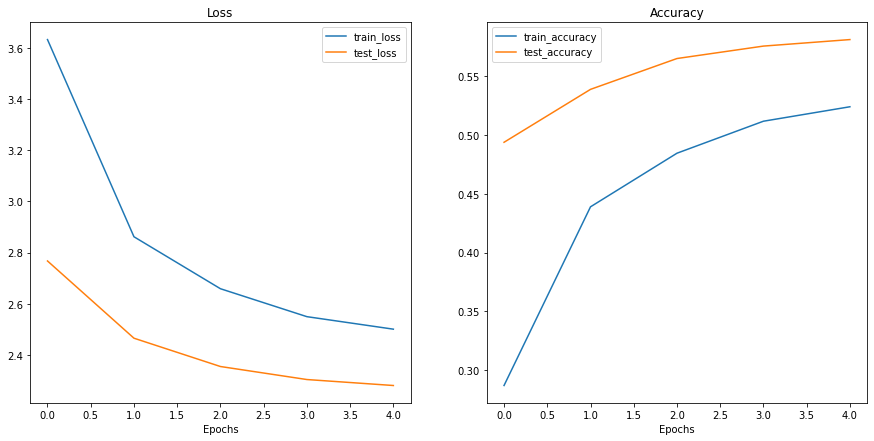

In [72]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

Nice!!!

It looks like our regularization techniques (data augmentation and label smoothing) helped prevent our model from overfitting (the training loss is still higher than the test loss) this indicates our model has a bit more capacity to learn and could improve with further training. 

### TK - Saving and loading FoodVision Big

Now we've trained our biggest model yet, let's save it so we can load it back in later.

In [73]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth" 

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


Model saved!

Let's make sure we can load it.

We'll do so by creating a model instance first with `create_effnetb2_model(num_classes=101)` (101 classes for all Food101 classes).

In [74]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

<All keys matched successfully>

### TK - Checking FoodVision Big model size

Our FoodVision Big model is capable of classifying 101 classes versus FoodVision Mini's 3 classes, a 33.6x increase!

How does this effect the model size?

Let's find out.

In [75]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


Hmm, it looks like the model size stayed largely the same (30 MB for FoodVision Big and 29 MB for FoodVision Mini) despite the large increase in the number of classes.

This is because all the extra parameters for FoodVision Big are *only* in the last layer (the classifier head). 

All of the base layers are the same between FoodVision Big and FoodVision Mini.

Going back up and comparing the model summaries will give more details.

| **Model** | **Output shape (num classes)** | **Trainable parameters** | **Total parameters** | **Model size (MB)** |
| ----- | ----- | ----- | ----- | ----- |
| FoodVision Mini (EffNetB2 feature extractor) | 3 | 4,227 | 7,705,221 |  29 |
| FoodVision Big (EffNetB2 feature extractor) | 101 | 142,309 | 7,843,303 | 30 |


## TK - Turning our FoodVision Big model into a deployable app

We've got a trained and saved EffNetB2 model on 20% of the Food101 dataset.

And instead of letting our model live in a folder all its life, let's deploy it!

We'll deploy our FoodVision Big model in the same way we deployed our FoodVision Mini model, as a Gradio demo on Hugging Face Spaces.

To begin, let's create a `demos/foodvision_big/` directory to store our FoodVision Big demo files as well as a `demos/foodvision_big/examples` directory to hold an example image to test the demo with.

When we're finished we'll have the following file structure:

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

Where:
* `09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth` is our trained PyTorch model file.
* `app.py` contains our FoodVision Big Gradio app.
* `class_names.txt` contains all of the class names for FoodVision Big.
* `examples/` contains example images to use with our Gradio app.
* `model.py` contains the model defintion as well as any transforms assosciated with the model.
* `requirements.txt` contains the dependencies to run our app such as `torch`, `torchvision` and `gradio`.

In [76]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

### Downloading an example image and moving it to the `examples` directory

For our example image, we're going to use the faithful `pizza-dad` image (a photo of my dad eating pizza).

So let's download it from the course GitHub via the `!wget` command and then we can move it to `demos/foodvision_big/examples` with the `!mv` command (short for "move").

While we're here we'll move our trained Food101 EffNetB2 model from `models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth` to `demos/foodvision_big` as well.

In [78]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg 
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2022-08-19 15:25:11--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: '04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  7.98MB/s    in 0.3s    

2022-08-19 15:25:11 (7.98 MB/s) - '04-pizza-dad.jpeg’ saved [2874848/2874848]



### TK - Saving Food101 class names to file (`class_names.txt`)

Because there are so many classes in the Food101 dataset, instead of storing them as a list in our app files, let's saved them to a `.txt` file and read them in when necessary instead.

We'll just remind ourselves what they look like first by checking out `food101_class_names`.

In [77]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

Wonderful, now we can write these to a text file by first creating a path to `demos/foodvision_big/class_names.txt` and then opening a file with Python's `open()` and then writing to it leaving a new line for each class.

Ideally, we want our class names to be saved like:

```
apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
...
```

In [83]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


Excellent, now let's make sure we can read them in.

To do so we'll use Python's [`open()`](https://www.w3schools.com/python/ref_func_open.asp) in read mode (`"r"`) and then use the [`readlines()`](https://www.w3schools.com/python/ref_file_readlines.asp) method to read each line of our `class_names.txt` file.

And we can save the class names to a list by stripping the newline value of each of them with a list comprehension and [`strip()`](https://www.w3schools.com/python/ref_string_strip.asp). 

In [84]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]
    
# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### TK - Turning our FoodVision Big model into a Python script (`model.py`)

Just like the FoodVision Mini demo, let's create a script that's capable of instantiating an EffNetB2 feature extractor model along with its necessary transforms.

In [86]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Overwriting demos/foodvision_big/model.py


### TK - Turning our FoodVision Big Gradio app into a Python script (`app.py`)

TK - This file is largely the same as FoodVision Mini but differs for the: model, class names, display text
* next: format to look nice

In [72]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]
    
### 2. Model and transforms preparation ###    

# Create model
model, transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
model.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

demo.launch()

Overwriting demos/foodvision_big/app.py


### TK - Creating a requirements file for FoodVision Big (`requirements.txt`)

In [73]:
%%writefile demos/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Overwriting demos/foodvision_big/requirements.txt


### TK - Downloading our FoodVision Big app files

In [74]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

updating: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
updating: app.py (deflated 49%)
updating: class_names.txt (deflated 48%)
updating: examples/ (stored 0%)
updating: examples/04-pizza-dad.jpeg (deflated 0%)
updating: flagged/ (stored 0%)
updating: model.py (deflated 46%)
updating: requirements.txt (deflated 4%)
Not running in Google Colab, can't use google.colab.files.download()


## TK - Deploying our FoodVision Big app to HuggingFace Spaces

TK - rather than repeating the steps, we'll folow the same steps as section XYZ for FoodVision Mini, except we'll make sure to give the Hugging Face Space a different name... 

See here for uploading to HuggingFace: https://huggingface.co/docs/hub/repositories-getting-started#getting-started-with-repositories

See the deployed app - https://huggingface.co/spaces/mrdbourke/foodvision_big/

TK image - gif of deployed app (what it looks like on Hugging Face Spaces when deployed

<iframe src="https://hf.space/embed/abidlabs/pytorch-image-classifier/+"></iframe>

In [91]:
from IPython.display import IFrame

IFrame(src="https://hf.space/embed/mrdbourke/foodvision_big/+", width=900, height=750)

## TK - Exercises
* Compare the model's prediction times on GPU vs CPU - does this close the gap?
* ViT seems to have more learning capacity than EffNetB2, how does it go on the larger Food101 dataset? - train for 5 epochs
    * Use same training setup as we've done for the EffNetB2 model
* Use the `pred_and_store()` function to predict across Food101 data and find the "most wrong"
    * Could put this function into `predictions.py`
* Evaluate best model across whole Food101 test dataset rather than just 20% - how does it perform?

## TK - Extra-curriculum

* More about Git and GitHub - "Git and GitHub for Beginners - Crash Course" on freeCodeCamp YouTube channel https://youtu.be/RGOj5yH7evk 
* More on Gradio: https://gradio.app/docs/ 
    * Check out all the different kinds of file components... 
    * Check out the Blocks API for more advanced workflows - https://gradio.app/docs/#blocks 
    * For more on Hugging Face and Gradio, see the Hugging Face Course chapter 9 https://huggingface.co/course/chapter9/1 
* PyTorch blog for deploying on raspberry pi (on edge)
* Chapter 7 ML Systems Design
* Made with ML MLOps section
* Google's People + AI Guidebook (how to design applications that use AI) - https://pair.withgoogle.com/guidebook/ 
    * More on this covered in ML monthly April 2021 - https://zerotomastery.io/blog/machine-learning-monthly-april-2021/

### TK - Try `torch.jit`?

TK - perhaps this could be an extension / extra-curriculum?

https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html

In [75]:
effnetb2_scripted = torch.jit.script(effnetb2)
vit_scripted = torch.jit.script(vit)
# effnetb2_scripted

### TK - How does `torch.jit` compare to non-jit? 